## Generating Training Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt


class ChaosAttractors():
    """
    Initial conditions for the systems to display chaotic behaviour are
    defined as follows:
    Lorenz 63 -> s = 10, r = 8/3, b = 28 and dt = 0.01
    """
    def __init__(self, steps, lrz_s=10, lrz_r=28, lrz_b=8/3, lrz_dt = 0.01,
                 rab_fab_a = 0.14, rab_fab_g = 0.1, rab_fab_dt = 0.01,
                 ros_a=0.2, ros_b=0.2, ros_c=6.3, ros_dt = 0.01):
        self.lrz_s = lrz_s
        self.lrz_b = lrz_b
        self.lrz_r = lrz_r
        self.lrz_dt = lrz_dt
        self.rab_fab_a = rab_fab_a
        self.rab_fab_g = rab_fab_g
        self.rab_fab_dt = rab_fab_dt
        self.ros_a = ros_a
        self.ros_b = ros_b
        self.ros_c = ros_c
        self.ros_dt = ros_dt
        self.steps = steps

    """Lorenz 63 System"""
    def lorenz63(self):
        xs = np.empty((self.steps + 1,))
        ys = np.empty((self.steps + 1,))
        zs = np.empty((self.steps + 1,))

        xs[0], ys[0], zs[0] = (1.0, 1.0, 1.0)
        for i in range(self.steps):
            x_dot = self.lrz_s*(ys[i] - xs[i])
            y_dot = self.lrz_r*xs[i] - ys[i] - xs[i]*zs[i]
            z_dot = xs[i]*ys[i] - self.lrz_b*zs[i]
            xs[i + 1] = xs[i] + (x_dot * self.lrz_dt)
            ys[i + 1] = ys[i] + (y_dot * self.lrz_dt)
            zs[i + 1] = zs[i] + (z_dot * self.lrz_dt)
        return xs, ys, zs


In [3]:
# use for ensemble forecast 
class Butterfly_attractor_ensemble():
    """
    Initial conditions for the systems to display chaotic behaviour are
    defined as follows:
    Lorenz 63 -> s = 10, r = 8/3, b = 28 and dt = 0.01
    """
    def __init__(self, steps, lrz_s=10, lrz_r=28, lrz_b=8/3, lrz_dt = 0.01):
        self.lrz_s = lrz_s
        self.lrz_b = lrz_b
        self.lrz_r = lrz_r
        self.lrz_dt = lrz_dt
        self.steps = steps

    """Lorenz 63 System"""
    def lorenz63(self,init_location,ensemble_size=1):
        xs = np.empty((self.steps + 1,ensemble_size))
        ys = np.empty((self.steps + 1,ensemble_size))
        zs = np.empty((self.steps + 1,ensemble_size))
        #init_location[0]
        xs[0,:] = init_location[0]
        ys[0,:] = init_location[1]
        zs[0,:] = init_location[2]

        xs[0,0] = init_location[0].mean(axis=0)
        ys[0,0] = init_location[1].mean(axis=0)
        zs[0,0] = init_location[2].mean(axis=0)

        #print(xs[0,:])
        #xs[0,:], ys[0,:], zs[0,:] = (init_location[0,:], init_location[1,:], init_location[2,:])
        for i in range(self.steps):
            x_dot = self.lrz_s*(ys[i] - xs[i])
            y_dot = self.lrz_r*xs[i] - ys[i] - xs[i]*zs[i]
            z_dot = xs[i]*ys[i] - self.lrz_b*zs[i]
            xs[i + 1] = xs[i] + (x_dot * self.lrz_dt)
            ys[i + 1] = ys[i] + (y_dot * self.lrz_dt)
            zs[i + 1] = zs[i] + (z_dot * self.lrz_dt)

        L     = np.matrix([[-self.lrz_s,self.lrz_s,0],[self.lrz_r-zs[0,0],-1,-xs[0,0]],[ys[0,0],xs[0,0],-self.lrz_b]])
        #L     = np.exp(np.diag(np.diagonal(L*self.lrz_dt)))
        #det   = np.linalg.det(L)
        det   = np.linalg.det(np.diag([1,1,1])+L*self.lrz_dt)

        # return variables including 
        # initial location = [xs[0], ys[0], zs[0]]
        # final location   = [xs[1], ys[1], zs[1]]
        # estimate determinant
        return [xs[0], ys[0], zs[0]],[xs[1], ys[1], zs[1]], det, [xs,ys,zs], np.diag([1,1,1])+L*self.lrz_dt

In [4]:
# Define length of the chaotic time series
attractors_series  = ChaosAttractors(10000)
# Obtain the time series for the Lorenz systems
lorenz_x, lorenz_y, lorenz_z = attractors_series.lorenz63()

# discard the first 1000 timesteps and use the rest for training 
lorenz_x = np.reshape(lorenz_x,[np.size(lorenz_x),1])[1000:,]
lorenz_y = np.reshape(lorenz_y,[np.size(lorenz_y),1])[1000:,]
lorenz_z = np.reshape(lorenz_z,[np.size(lorenz_z),1])[1000:,]
data     = np.concatenate([lorenz_x,lorenz_y,lorenz_z],axis=1)

## Define Reservour Computing

In [5]:
# reservoir computing
from scipy import linalg
class reservoir():
  def __init__(self, trainLen=int, testLen=int, initLen=int, inSize=int, outSize = int,
                 resSize = int, a = float, seed = int,
                 reg=float):
    self.trainLen = trainLen   # length for training
    self.testLen  = testLen    # length for testing
    self.initLen  = initLen    # length for initialization
    self.inSize   = inSize     # input variable dimension
    self.outSize  = outSize    # output variable dimension
    self.resSize  = resSize    # reservoir size (how many past states are used)
    self.a        = a          # leaking rate
    self.seed     = seed       # experiment number (any number bigger than 0, if seed=0, randomly initialized)
    self.reg      = reg        # regularization intensity (regid by default)


  def training(self, data): # data should have a dimension of [time X variable]
    if self.seed==0:
      np.random.seed()
    else:
      np.random.seed(self.seed)

    # preparing regression coefficient
    Win   = (np.random.rand(self.resSize,1+self.inSize) - 0.5) * 1
    W     = np.random.rand(self.resSize,self.resSize) - 0.5
    # normalizing and setting spectral radius (correct, slow):
    print('Computing spectral radius...')
    rhoW  = max(abs(linalg.eig(W)[0]))
    print('done.')
    W    *= 1.25 / rhoW

    # allocated memory for the design matrix (collected states including the input from current step and past step)
    X     = np.zeros((1+self.inSize+self.resSize,self.trainLen-self.initLen))
    # set the corresponding target matrix directly
    Yt    = data[None,self.initLen+1:self.trainLen+1]


    # run the reservoir with the data and collect X
    x = np.zeros((self.resSize,1))  # input from current time step
    for t in range(self.trainLen):
        u    = data[t,:]
        u    = np.reshape(u,[self.inSize,1])
        unit = np.ones((1,1))
        x    = (1-self.a)*x + self.a*np.tanh( np.dot( Win, np.vstack((1,u))) + np.dot( W, x ) )

        # after initialization step, stacking the input from current step and latent state together
        if t >= self.initLen:
            X[:,t-self.initLen] = np.vstack((1,u,x))[:,0]

    # train the output layer with Normal Equation method (+ rigid regularization)
    Wout = linalg.solve( np.dot(X,X.T) + self.reg*np.eye(1+self.inSize+self.resSize), np.dot(X,Yt.T) ).T
    #return all variables at t=trainLen
    return x, Win, W, Wout

  def training_testing(self,data):
    # training the model
    x, Win, W, Wout = self.training(data)

    # run the trained ESN in a generative mode. no need to initialize here,
    # because x is initialized with training data and we continue from there. (all parameters are frozen)
    Y        = np.zeros((self.outSize,self.testLen)) # the forecast value
    u        = data[self.trainLen,:]                 # the input for steps at trainLen
    u        = np.reshape(u,[self.inSize,1])
    unit     = np.ones((1,1))
    x_record = x.copy()
    for t in range(self.testLen):
        x      = (1-self.a)*x + self.a*np.tanh( np.dot( Win, np.vstack((unit,u)) ) + np.dot( W, x ) )
        y      = np.dot( Wout, np.vstack((1,u,x)) )
        Y[:,t] = np.squeeze(y)
        # generative mode:
        u      = y                                   # using the forecast value as the next time step input
        u      = np.reshape(u,[self.inSize,1])
        ## this would be a predictive mode:
        #u = data[trainLen+t+1]


    # compute MSE for the first errorLen time steps
    errorLen = 500
    mse      = sum( np.square( data[self.trainLen+1:self.trainLen+errorLen+1] - np.transpose(Y[:,0:errorLen]) ) ) / errorLen
    print('MSE = ' + str( mse ))

    # model output
    plt.figure()
    plt.plot(Y[0,:],Y[1,:],'k')
    # ground truth
    plt.figure()
    plt.plot(data[self.trainLen+1:self.trainLen+self.testLen+1,0],data[self.trainLen+1:self.trainLen+self.testLen+1,1],'r')

    return Y, x_record, Win, W, Wout

  def prediction(self,data,x_record,Win,W,Wout,ensemble_size=1000,forecast_time=2000):
    # data_ensemble is the ensemble centering around the last training step


    data_ensemble      = np.zeros((self.inSize,ensemble_size))
    data_ensemble[:,0] = data[:]       # the first member has no perturbation
    for i in range(self.inSize):       # other members have perturbation
        data_ensemble[i,1:] = data[i]+np.random.normal(loc=0.0, scale=0.001, size=ensemble_size-1)
    u                  = data_ensemble
    u                  = np.reshape(u,[self.inSize,ensemble_size])
    x                  = np.repeat(x_record, ensemble_size, axis=1)           # repeat the hidden state (identical for all ensemble)
    Y                  = np.zeros((self.inSize,ensemble_size,forecast_time))  # array for saving forecast results
    Y[:,:,0]           = u
    unit               = np.ones((1,ensemble_size))
    for t in range(forecast_time-1):
        x = (1-self.a)*x + self.a*np.tanh( np.dot( Win, np.vstack((unit,u)) ) + np.dot( W, x ) )
        y = np.dot( Wout, np.vstack((unit,u,x)) )
        Y[:,:,t+1] = np.squeeze(y)
        # generative mode:
        u = y
        u = np.reshape(u,[self.inSize,ensemble_size])



    # Y             = forecast value
    # x             = latent state
    # data_ensemble = initially_perturbed_ensemble  (initial Y)
    return Y, x, data_ensemble

### THe following script is for training only. One can load a pre-trained model provided in the GitHub

Computing spectral radius...
done.
MSE = [0.03872336 0.09451566 0.21142486]


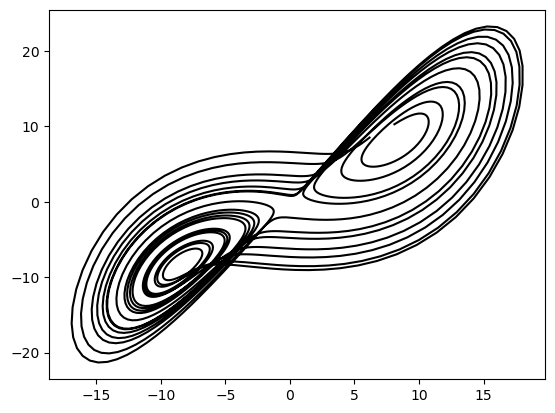

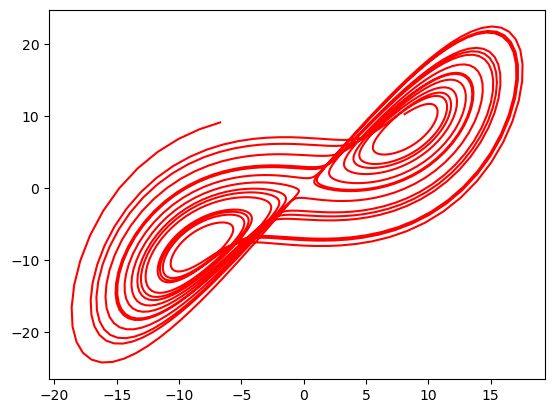

In [6]:
# you might need to try multiple times to get a stable model
# del model
model = reservoir(trainLen= 3000, testLen=2000, initLen=100, inSize=3, outSize = 3,
                  resSize = 2000, a = 0.3, seed = 0,
                  reg=1e-2)
Y, x_record, Win, W, Wout     = model.training_testing(data)

In [8]:
## used developed model for forecast 
del model
model = reservoir(trainLen= 3000, testLen=2000, initLen=100, inSize=3, outSize = 3,
                  resSize = 2000, a = 0.3, seed = 0,
                  reg=1e-2)
Y_ML, x_record_new,data_ensemble = model.prediction(data[3000,:],x_record,Win,W,Wout,ensemble_size=2,forecast_time=3000)


In [ ]:
### load pre-trained model (or one can use their own model)

In [9]:
# load a pre-trained model
best_model = np.load('parameter_count40.npz')

#best_model = np.load('/content/drive/MyDrive/Colab/2021_research/Next-generation_probabilistic_forecast/reservoir_model/best_ESN_LR63_model.npz')

x_record = best_model['x_record']
a        = best_model['a']
Win      = best_model['Win']
Wout     = best_model['Wout']
W        = best_model['W']
u        = data[2050,:]

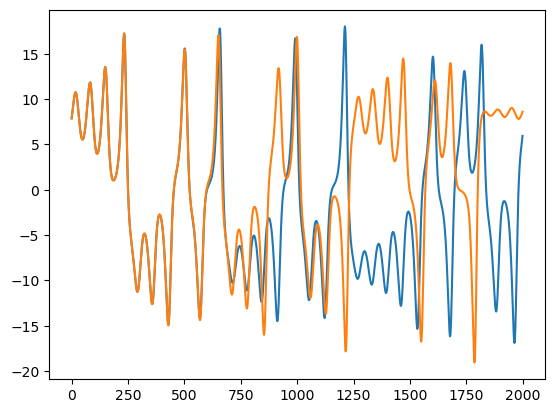

In [10]:
plt.plot(Y_ML[0,:,0:2000].T)

Text(0.5, 1.0, 'ML-based butterfly simulations, ensemble=2')

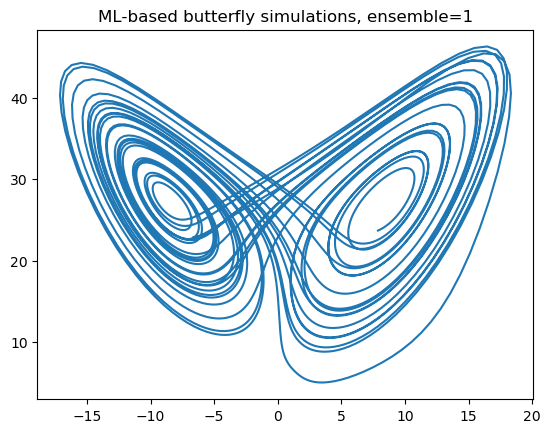

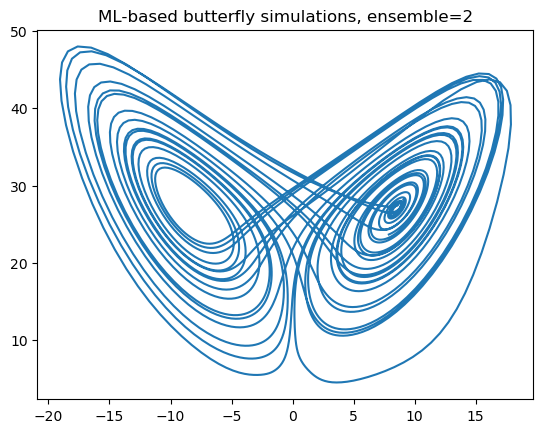

In [11]:
np.shape(Y_ML)
plt.figure()
plt.plot(Y_ML[0,0,:],Y_ML[2,0,:])
plt.title('ML-based butterfly simulations, ensemble=1')

plt.figure()
plt.plot(Y_ML[0,1,:],Y_ML[2,1,:])
plt.title('ML-based butterfly simulations, ensemble=2')

In [ ]:
# calculate the determinant of Jacobian matrix
# calculate linear tangent for each step
del model
model = reservoir(trainLen= 3000, testLen=2000, initLen=100, inSize=3, outSize = 3,
                  resSize = 2000, a = 0.3, seed = 0,
                  reg=1e-2)

total_forecast_time = 7000 # total time steps after the initial training
ensemble_size       = 5    # ensemble size
Y_ML                = np.zeros((3,total_forecast_time+1))
Y_ML[:,0]           = data[3000,:] # 3000 = initial training length
Y_ML_ensemble       = np.zeros((3,ensemble_size,total_forecast_time+1))
#Y_ML[:,0]           = u
Y_numerical         = np.zeros((3,total_forecast_time+1))
Y_numerical[:,0]    = data[3000,:]
Y_numerical_ensemble = np.zeros((3,ensemble_size,total_forecast_time+1))
#Y_numerical[:,0]    = u
x_record_new        = x_record
det_ML              = np.zeros((total_forecast_time,1))
det_numerical       = np.zeros((total_forecast_time,1))

lambda_ML                  = np.zeros((total_forecast_time,1))
lambda_min_ML              = np.zeros((total_forecast_time,1))
lambda_det_ML              = np.zeros((total_forecast_time,1))
lambda_numerical           = np.zeros((total_forecast_time,1))
lambda_min_numerical       = np.zeros((total_forecast_time,1))
lambda_det_numerical       = np.zeros((total_forecast_time,1))
#del model3
model3              = Butterfly_attractor_ensemble(1)

for i in range(1,total_forecast_time+1):
    # Y_template = ensemble mean, x_record_template = the latent state of ensemble mean, and data_ensemble
    Y_template , x_record_template,data_ensemble = model.prediction(np.squeeze(Y_ML[:,i-1]),x_record_new,Win,W,Wout,ensemble_size=ensemble_size,forecast_time=2)
    Y_ML_ensemble[:,:,i]                         = Y_template[:,:,1]
    Y_ML[:,i]                                    = np.squeeze(Y_template[:,:,1].mean(axis=1))
    x_record_new                                 = np.reshape(x_record_template[:,:].mean(axis=1),np.shape(x_record))
    #print(np.shape(Y_template))
    # # estimate the determinant of a linear tangent function
    dx_init  = data_ensemble
    dx_final = Y_template[:,:,1]
    L1       = dx_final.dot(dx_init.T).dot(linalg.inv(dx_init.dot(dx_init.T))) # linear tangent function
    v,m      = linalg.eig(L1.T.dot(L1))
    v        = np.matrix(v)
    v_diagonal = np.matrix(np.zeros((3,3)))
    np.fill_diagonal(v_diagonal, v)
    #print(np.around(L1,3))
    lambda_ML[i-1,0]     = np.max(v_diagonal.getH().dot(v_diagonal))**0.5
    lambda_det_ML[i-1,0] = np.linalg.det(v_diagonal)
    v_diagonal = np.matrix(np.ones((3,3)))
    np.fill_diagonal(v_diagonal, v)
    lambda_min_ML[i-1,0] = np.min(v_diagonal.getH().dot(v_diagonal))**0.5
    det_ML[i-1,0]        = np.linalg.det(np.around(L1,3))


    data_ensemble,Y_template, det_template,Y_numerical_template,L2          = model3.lorenz63(data_ensemble,ensemble_size)
    data_ensemble                                                           = np.array(data_ensemble)
    Y_numerical[:,i]                                                        = np.array(Y_template).mean(axis=1)
    Y_numerical_ensemble[:,:,i]                                             = np.array(Y_template)
    dx_init   = data_ensemble
    dx_final  = np.array(Y_template)
    #L2        = dx_final.dot(dx_init.T).dot(linalg.inv(dx_init.dot(dx_init.T))) # linear tangent function
    v,m       = linalg.eig(L2.T.dot(L2))
    v          = np.matrix(v)
    v_diagonal = np.matrix(np.zeros((3,3)))
    np.fill_diagonal(v_diagonal, v)
    #print(v_diagonal)
    #print(np.around(L1,3))
    lambda_numerical[i-1,0]     = np.max(v_diagonal.getH().dot(v_diagonal))**0.5
    lambda_det_numerical[i-1,0] = np.linalg.det(v_diagonal)
    v_diagonal                = np.matrix(np.ones((3,3)))
    np.fill_diagonal(v_diagonal, v)
    lambda_min_numerical[i-1,0] = np.min(v_diagonal.getH().dot(v_diagonal))**0.5
    det_numerical[i-1,0]        = np.linalg.det(np.around(L2,3))




# import numpy as np
# from scipy import signal
# filtered = signal.convolve(det_ML[:,0], [1,2,1], mode='same') / sum([1,2,1])


/Users/Shared/miniconda3/envs/default_env/lib/python3.9/site-packages/numpy/lib/index_tricks.py:910: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val


In [ ]:
v_diagonal.getH().dot(v_diagonal)

matrix([[2.42575593, 2.82580564, 2.59995924],
        [2.82580564, 3.37664671, 3.12076538],
        [2.59995924, 3.12076538, 2.89767948]])

(0.0, 7000.0)

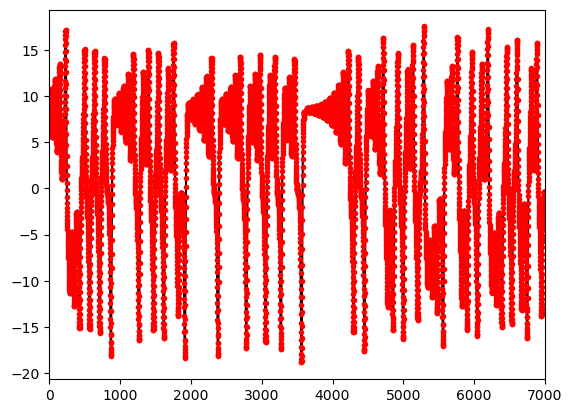

In [ ]:
plt.figure()
plt.plot(Y_ML[0,0:total_forecast_time],'k')
plt.plot(Y_numerical[0,0:total_forecast_time],'r.')
plt.xlim([0,total_forecast_time])


(7000, 1)

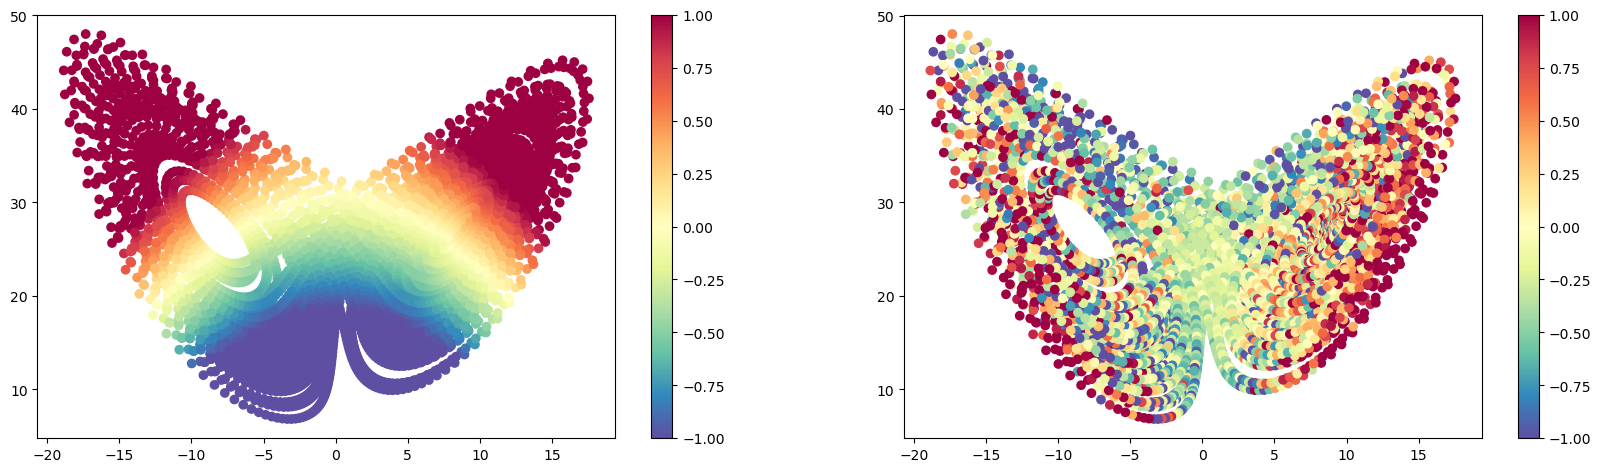

In [ ]:
import matplotlib.cm as cm
lag = 0
#series1 = (det_ML[0:2000-lag]-np.mean(det_ML[0:2000-lag]))/np.std(det_ML[0:2000-lag])
series1 = (det_ML[0:total_forecast_time]-np.mean(det_ML[0:total_forecast_time]))/np.std(det_ML[0:total_forecast_time])
series2 = (det_numerical[0:total_forecast_time]-np.mean(det_numerical[0:total_forecast_time]))/np.std(det_numerical[0:total_forecast_time])
#series2 = (lambda_numerical[0:2000]-np.mean(lambda_numerical[0:2000]))/np.std(lambda_numerical[0:2000])
#series1 = (lambda_ML[0:2000]-np.mean(lambda_ML[0:2000]))/np.std(lambda_ML[0:2000])
#series2 = (lambda_min_numerical[0:2000-lag]-np.mean(lambda_min_numerical[0:2000-lag]))

fig = plt.figure()
plt.subplot(1,2,2)
cs=plt.scatter(Y_ML[0,lag:total_forecast_time],Y_ML[2,lag:total_forecast_time], c=series1,cmap='Spectral_r',vmax=1,vmin=-1)
plt.colorbar(cs)
plt.subplot(1,2,1)
cs=plt.scatter(Y_numerical[0,:total_forecast_time],Y_numerical[2,:total_forecast_time], c=series2,cmap='Spectral_r',vmax=1,vmin=-1)
plt.colorbar(cs)
fig.set_size_inches(20.5, 5.5)


np.shape(series1)
np.shape(series2)

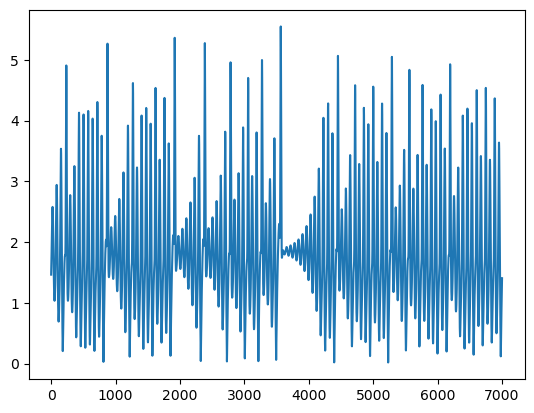

In [ ]:
x_coordinate = 0
z_coordinate = 20
distance     = ((Y_ML[0,:]-x_coordinate)**2+(Y_ML[2,:]-z_coordinate)**2)**0.5
distance     = distance/np.std(distance)
plt.plot(distance)
threshold    = np.percentile(distance,5)
posi         = np.squeeze(np.where(distance<threshold))
y_coordinate = Y_ML[1,posi].mean(axis=0)

# assign initial probability to data point

from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[x_coordinate,y_coordinate,z_coordinate], cov=[[1,0,0],[0,1,0],[0,0,1]])
rho = np.zeros(np.size(Y_ML[0,:]))
rho_space  = np.zeros((101,101,101))
# x_sequence = np.arange(x_coordinate-25,x_coordinate+25.5,0.5)
# y_sequence = np.arange(y_coordinate-25,y_coordinate+25.5,0.5)
# z_sequence = np.arange(z_coordinate-25,z_coordinate+25.5,0.5)
for i in range(np.size(Y_ML[0,:])):
    rho[i] = var.pdf([Y_ML[0,i],Y_ML[1,i],Y_ML[2,i]])

# for i in range(np.sisze(x_sequence)):
#     for j in range(np.size(x_sequence)):
#         for k in range(np.size(x_sequence)):
#             rho_space[i,j,k] = var.pdf([x_sequence[i],y_sequence[j],z_sequence[k]])

In [ ]:
import numpy as np
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
grid_x, grid_y = np.mgrid[Y_ML[0,posi], Y_ML[0,posi]]
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])

from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
np.shape(grid_z0)
#plt.contourf()

AttributeError: 'numpy.ndarray' object has no attribute 'step'

In [ ]:
np.shape(grid_x)

(100, 200)

[[1.        0.9717951]
 [0.9717951 1.       ]]


(7000, 1)

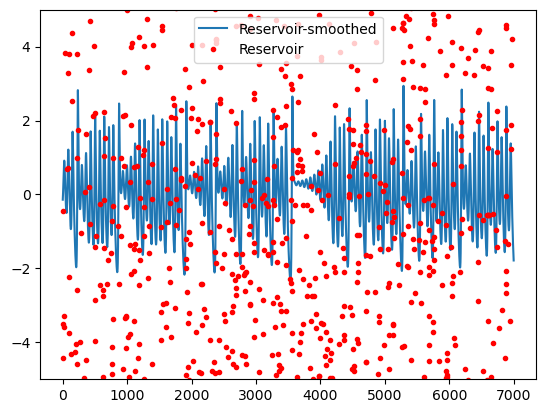

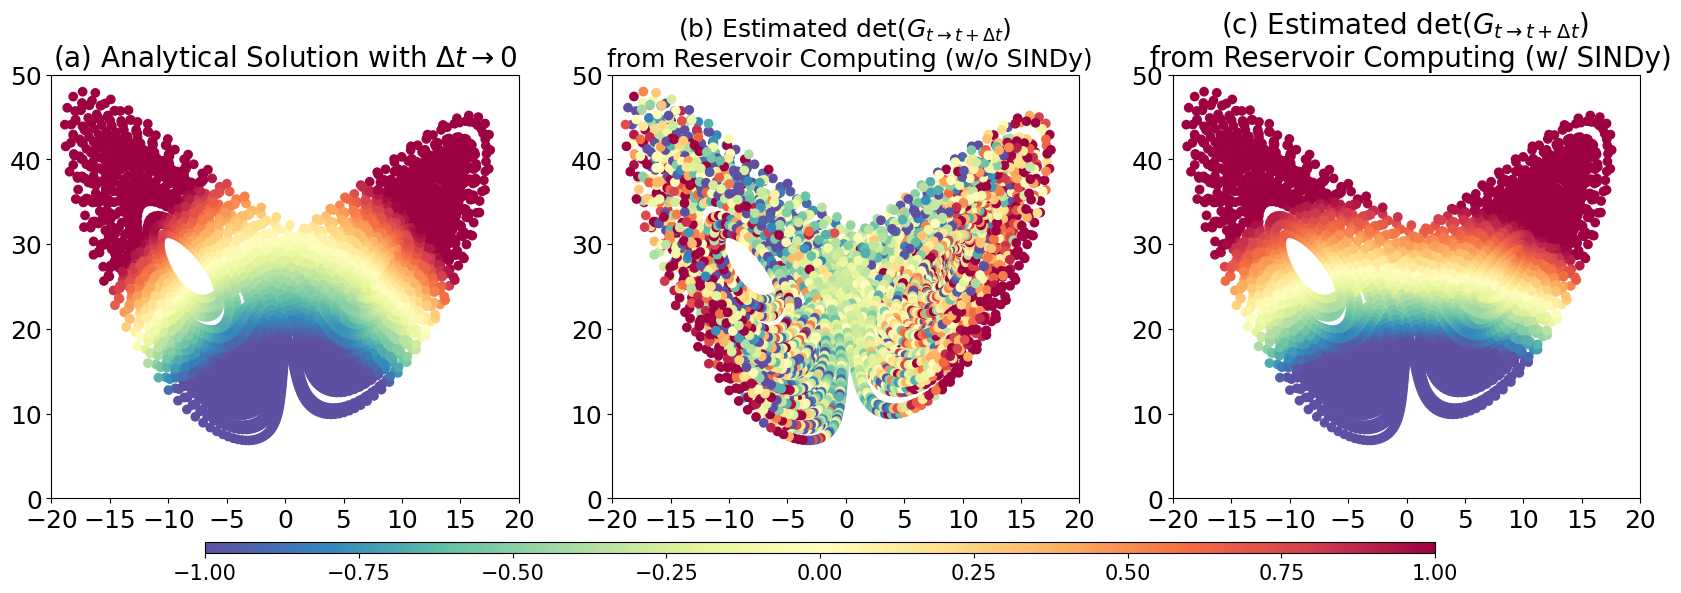

In [ ]:
# using normal equation for calibration

def normal_equation(predictor,predictant, using_bias=False):
    if using_bias:
        # predictor should have a dimension of time X number of predictors
        X_mat              = np.vstack((np.ones(predictor.shape[0]), predictor)).T

        # coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
        # coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a
        # predictamt should have dimension of time X number of targets
        coef               = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(predictant)

    else:
        # predictor should have a dimension of time X number of predictors
        X_mat              = predictor.T

        # coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
        # coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a
        # predictamt should have dimension of time X number of targets
        coef               = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(predictant)

    return coef



x = Y_ML[0,:total_forecast_time]
y = Y_ML[1,:total_forecast_time]
z = Y_ML[2,:total_forecast_time]
xy = np.multiply(x,y)
yz = np.multiply(y,z)
xz = np.multiply(x,z)
xx = np.multiply(x,x)
yy = np.multiply(y,y)
zz = np.multiply(z,z)
#xyz = np.multiply(xy,z)


predictor   = np.matrix([x,y,z,xy,yz])
coef        = normal_equation(predictor,det_ML[:total_forecast_time,0], using_bias=False)
#coef        = normal_equation(predictor,lambda_ML[1:1701,0], using_bias=False)
det_predict = coef.dot(predictor)

series1 = np.array((det_ML-np.mean(det_ML))/np.std(det_ML))
series2 = np.array((det_numerical-np.mean(det_numerical))/np.std(det_numerical))
series3 = np.array((det_predict.T-np.mean(det_predict.T))/np.std(det_predict.T))

plt.figure()
#plt.plot(series1)
plt.plot(series3,label='Reservoir-smoothed')
#plt.plot(series2,'k.',label='analytical')
plt.plot((series1[:total_forecast_time]-1)*20,'r.',label='Reservoir')
plt.ylim([-5,5])
plt.legend()

fig = plt.figure()
plt.subplot(1,3,2)
cs=plt.scatter(Y_ML[0,:total_forecast_time],Y_ML[2,:total_forecast_time], c=series1[:total_forecast_time],cmap='Spectral_r',vmax=1,vmin=-1)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(b) Estimated $\mathrm{det}(G_{t\rightarrow t+\Delta t})$ '+'\n from Reservoir Computing (w/o SINDy)',fontsize=18)

plt.subplot(1,3,1)
cs=plt.scatter(Y_numerical[0,:total_forecast_time],Y_numerical[2,:total_forecast_time], c=series2,cmap='Spectral_r',vmax=1,vmin=-1)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(a) Analytical Solution with $\Delta t\rightarrow 0$',fontsize=20)

plt.subplot(1,3,3)
cs=plt.scatter(Y_numerical[0,:total_forecast_time],Y_numerical[2,:total_forecast_time], c=series3[:total_forecast_time],cmap='Spectral_r',vmax=1,vmin=-1)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(c) Estimated $\mathrm{det}(G_{t\rightarrow t+\Delta t})$ '+'\n from Reservoir Computing (w/ SINDy)',fontsize=20)

fig.set_size_inches(20.5, 5.5)

cbaxes = fig.add_axes([0.2, 0.01, 0.6, 0.02])
cb = plt.colorbar(cs, cax = cbaxes, orientation="horizontal")
cb.ax.tick_params(labelsize=15)
print(np.corrcoef(series2.T,series3[0:total_forecast_time].T))
#fig.tight_layout()
#fig.savefig('FIGS1.jpg', dpi=300, bbox_inches='tight')
np.shape(series2)

In [ ]:
np.shape(predictor)

(5, 7000)

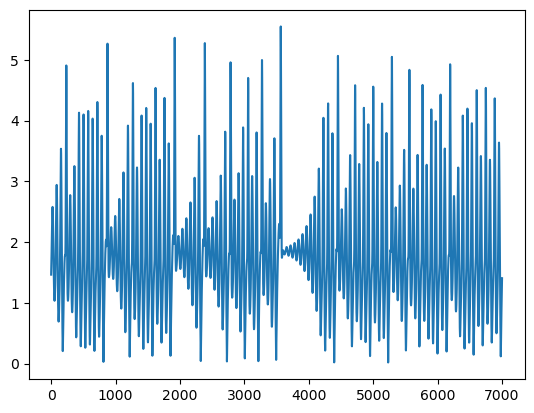

In [ ]:

x_coordinate = 0
z_coordinate = 20
distance     = ((Y_ML[0,:]-x_coordinate)**2+(Y_ML[2,:]-z_coordinate)**2)**0.5
distance     = distance/np.std(distance)
plt.plot(distance)
threshold    = np.percentile(distance,5)
posi         = np.squeeze(np.where(distance<threshold))
y_coordinate = Y_ML[1,posi].mean(axis=0)

# assign initial probability to data point

from scipy.stats import multivariate_normal
var    = multivariate_normal(mean=[x_coordinate,y_coordinate,z_coordinate], cov=[[5,0,0],[0,5,0],[0,0,5]])
rho    = np.zeros((np.size(Y_ML[0,:5000]),500))

for i in range(np.size(Y_ML[0,:5000])):
    rho[i,0] = var.pdf([Y_ML[0,i],Y_ML[1,i],Y_ML[2,i]])

In [ ]:
y_coordinate

-0.07612266118631641

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# target grid to interpolate to
xi = zi       = np.arange(-20,50.01,0.01)
xi,zi         = np.meshgrid(xi,zi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
rho_space = griddata((Y_ML[0,:5000],Y_ML[2,:5000]),rho[:,0],(xi,zi),method='linear')

(1, 7000)


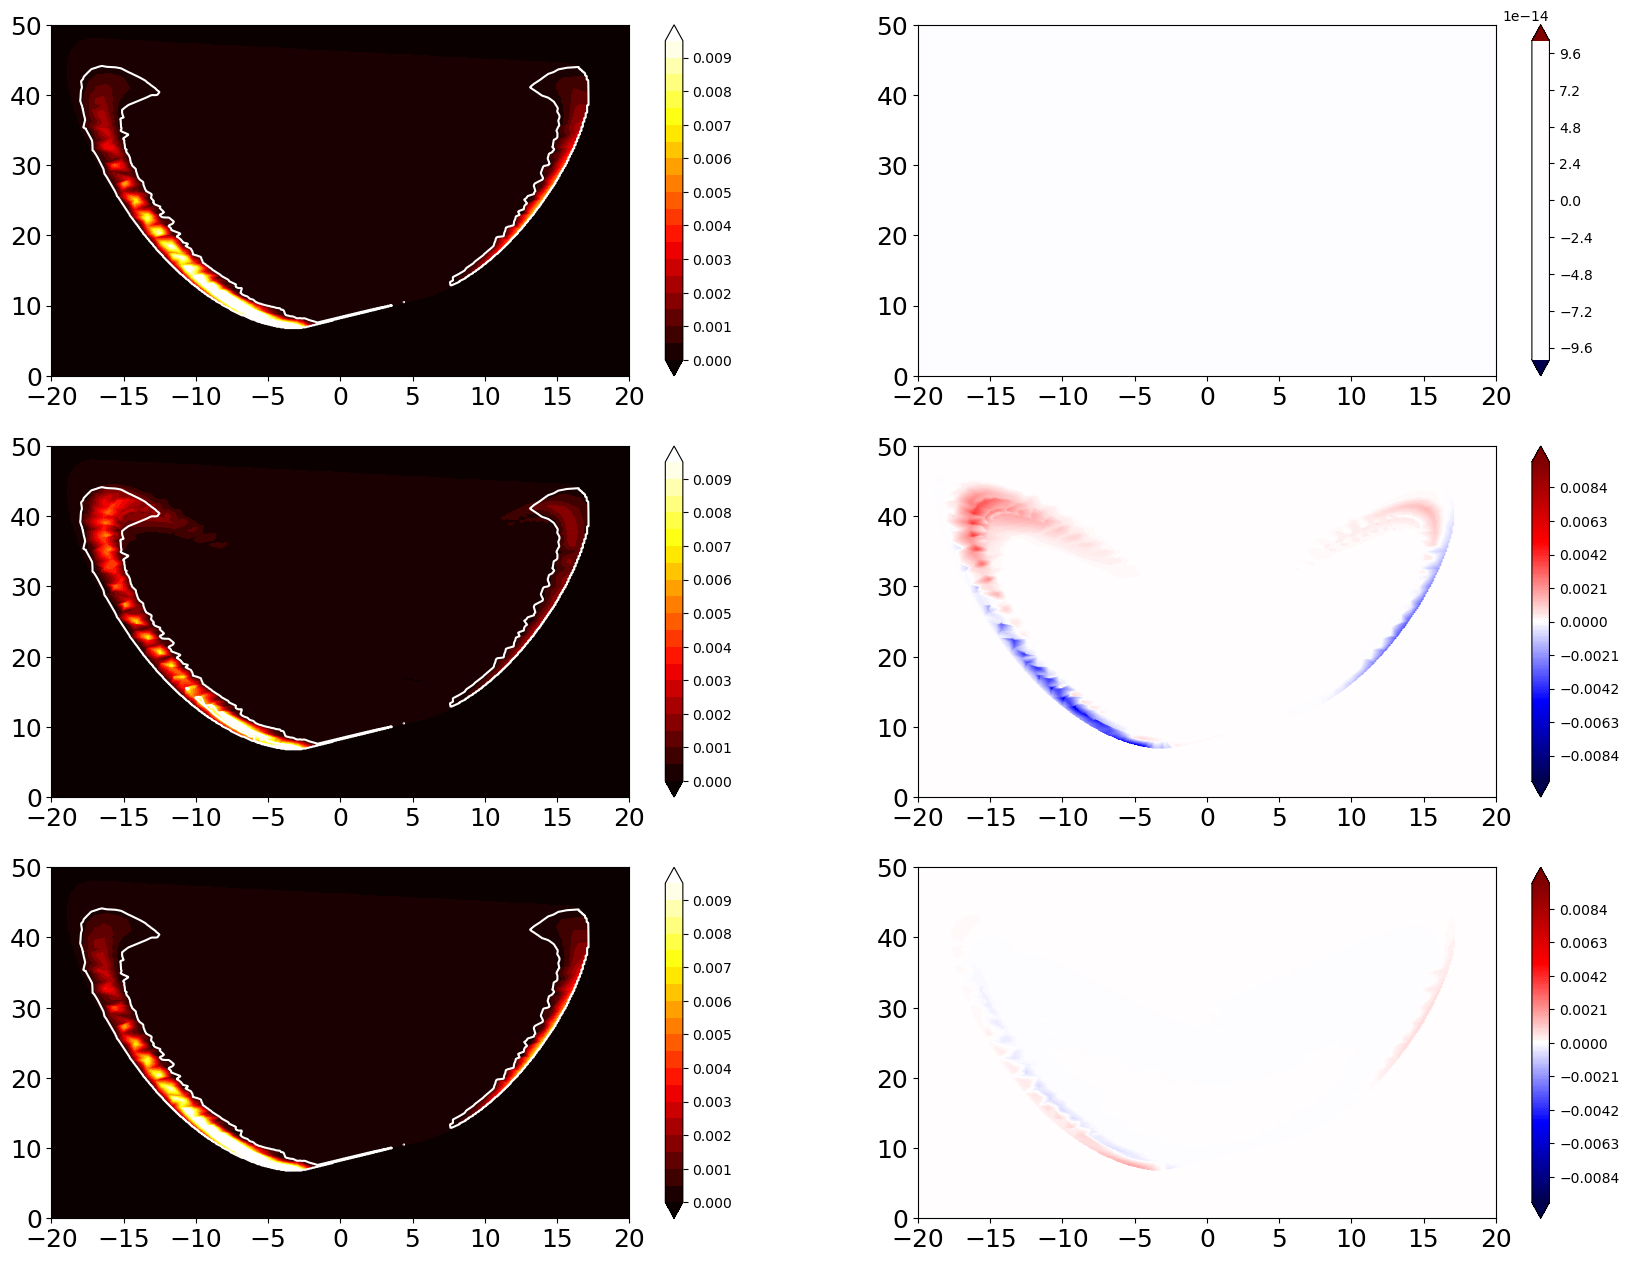

In [ ]:
print(np.shape(det_predict))
rho_ML        = np.zeros(np.shape(rho))
rho_numerical = np.zeros(np.shape(rho))
rho_SINDy     = np.zeros(np.shape(rho))

rho_ML[:,0]          = rho[:,0]
rho_numerical[:,0]   = rho[:,0]
rho_SINDy[:,0]       = rho[:,0]

for t in range(47):
    rho_ML[:,t+1] = np.reshape(np.reshape(rho_ML[:,t],[5000,1])*(1-np.array(series1[0+t:5000+t,])*0.05),[5000,])
    rho_ML[:,t+1] = rho_ML[:,t+1]/np.sum(rho_ML[:,t+1])

    rho_numerical[:,t+1] = np.reshape(np.reshape(rho_numerical[:,t],[5000,1])*(1-np.array(series2[0+t:5000+t,])*0.05),[5000,])
    rho_numerical[:,t+1] = rho_numerical[:,t+1]/np.sum(rho_numerical[:,t+1])

    rho_SINDy[:,t+1] = np.reshape(np.reshape(rho_SINDy[:,t],[5000,1])*(1-np.array(series3[0+t:5000+t,])*0.05),[5000,])
    rho_SINDy[:,t+1] = rho_SINDy[:,t+1]/np.sum(rho_SINDy[:,t+1])

    #print(np.shape(rho[:,0]*det_ML[0+t:5000+t,].T))


import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# target grid to interpolate to
xi = zi       = np.arange(-20,50.1,0.1)
xi,zi         = np.meshgrid(xi,zi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
rho_space_ML        = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_ML[:,t],(xi,zi),method='linear')
rho_space_numerical = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_numerical[:,t],(xi,zi),method='linear')
rho_space_SINDy     = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_SINDy[:,t],(xi,zi),method='linear')

posi = np.where(np.isnan(rho_space_ML))
rho_space_ML[posi] = 0
posi = np.where(np.isnan(rho_space_numerical))
rho_space_numerical[posi] = 0
posi = np.where(np.isnan(rho_space_SINDy))
rho_space_SINDy[posi] = 0


threshold = np.percentile(rho_space_numerical,97)


fig=plt.figure()
plt.subplot(3,2,1)
cs=plt.contourf(xi,zi,rho_space_numerical,levels=np.arange(0,0.01,0.0005),cmap='hot',extend='both')
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
plt.colorbar(cs)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.subplot(3,2,2)
cs=plt.contourf(xi,zi,rho_space_numerical-rho_space_numerical, 30,vmin=-0.005, vmax=0.005,cmap='seismic',extend='both')
plt.colorbar(cs)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.subplot(3,2,3)
cs=plt.contourf(xi,zi,rho_space_ML,levels=np.arange(0,0.01,0.0005),cmap='hot',extend='both')
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
#plt.contour(xi[::4,::4],zi[::4,::4],rho_space_numerical[::4,::4],[threshold,threshold+0.01],colors='y',linestyles='dotted',linewidths=5)
plt.colorbar(cs)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.subplot(3,2,4)
cs=plt.contourf(xi,zi,rho_space_ML-rho_space_numerical,levels=np.arange(-0.01,0.0101,0.0001),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
#fig.set_size_inches(20.5, 5.5)


plt.subplot(3,2,5)
cs=plt.contourf(xi,zi,rho_space_SINDy,levels=np.arange(0,0.01,0.0005),cmap='hot',extend='both')
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
#plt.contour(xi[::4,::4],zi[::4,::4],rho_space_numerical[::4,::4],[threshold,threshold+0.01],colors='y',linestyles='dotted',linewidths=5)
plt.colorbar(cs)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.subplot(3,2,6)
cs=plt.contourf(xi,zi,rho_space_SINDy-rho_space_numerical, levels=np.arange(-0.01,0.0101,0.0001),cmap='seismic',extend='both')
plt.colorbar(cs)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
fig.set_size_inches(20.5, 15.5)



/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_25335/1930554527.py:34: UserWarning: The following kwargs were not used by contour: 'linwidth'
  plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='k',linwidth=5)
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_25335/1930554527.py:44: UserWarning: The following kwargs were not used by contour: 'linwidth'
  plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='k',linwidth=5)
/var/folders/x1/nb2x5h5j08b2xx8xkc64r43m0000gn/T/ipykernel_25335/1930554527.py:53: UserWarning: The following kwargs were not used by contour: 'linwidth'
  plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='k',linwidth=5)


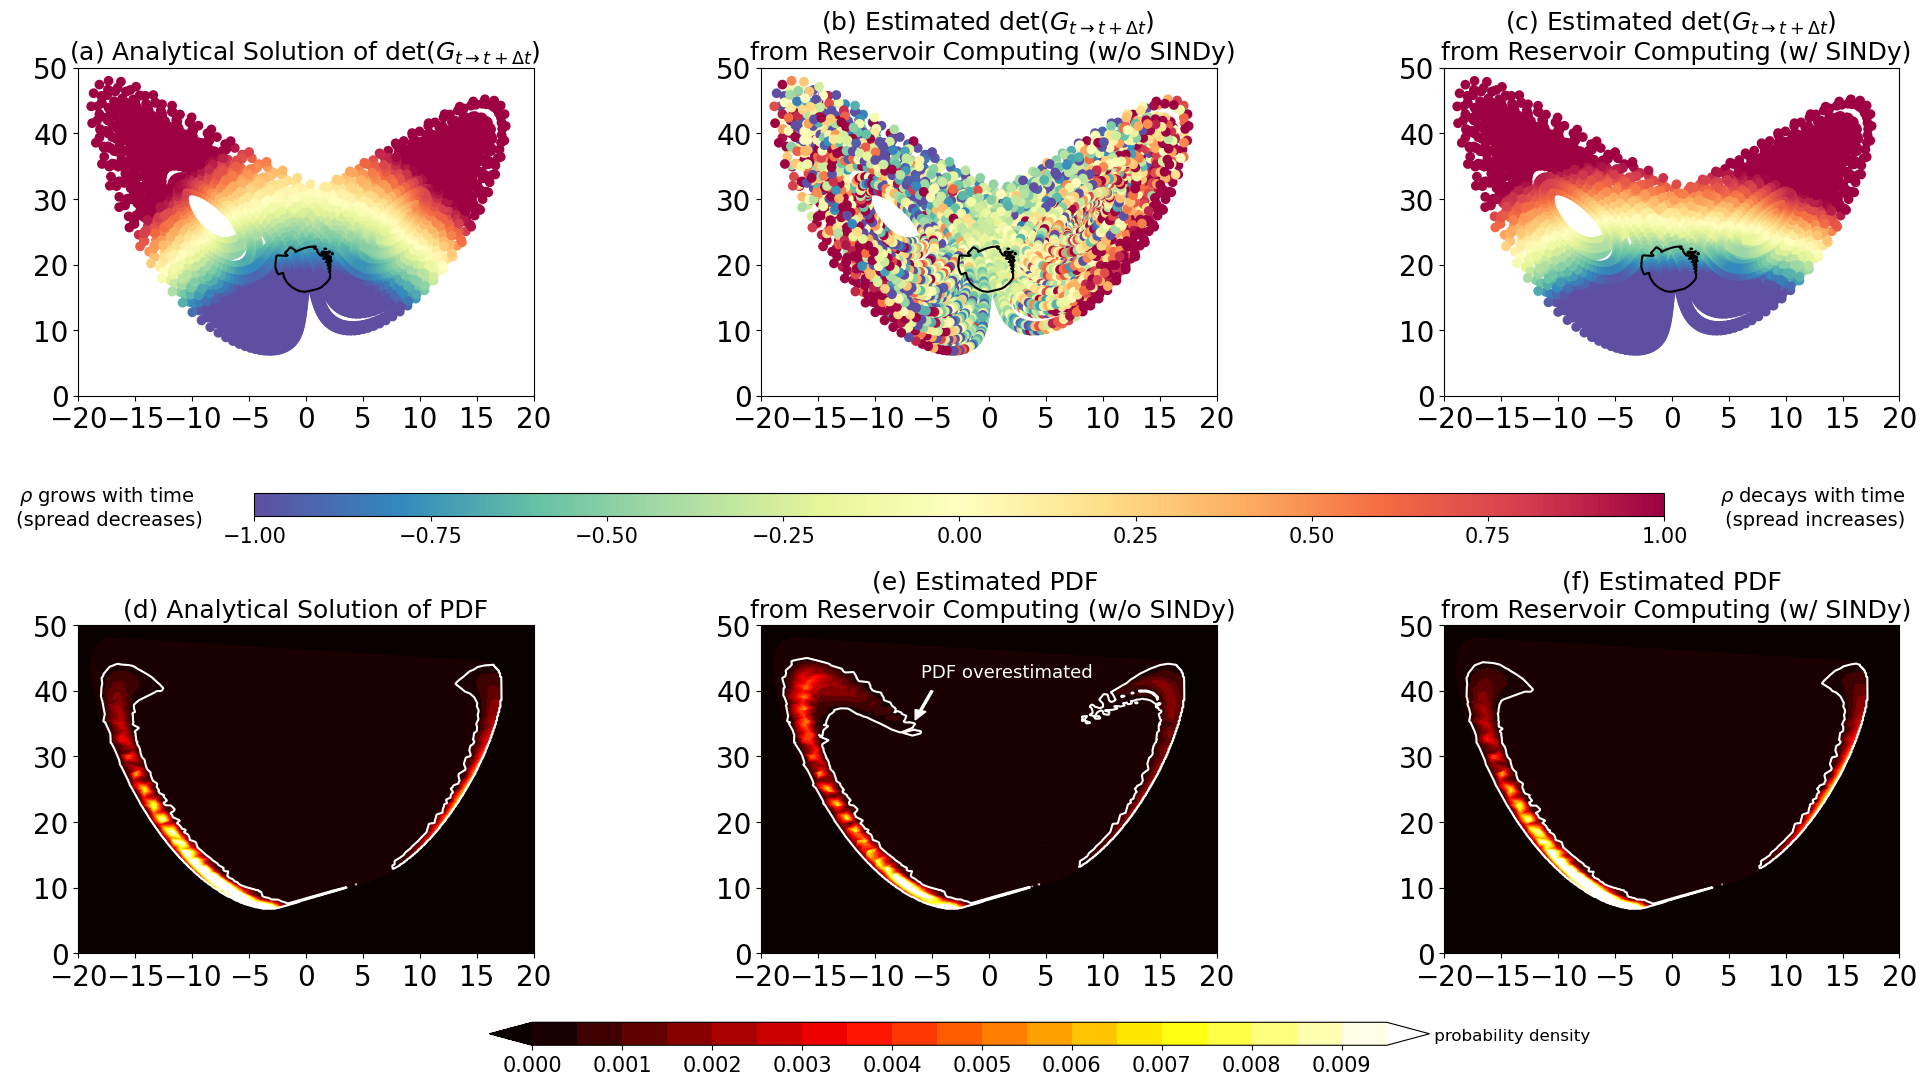

In [ ]:
t  = 1

# target grid to interpolate to
xi = zi       = np.arange(-20,50.1,0.1)
xi,zi         = np.meshgrid(xi,zi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
rho_space_ML        = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_ML[:,t],(xi,zi),method='linear')
rho_space_numerical = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_numerical[:,t],(xi,zi),method='linear')
rho_space_SINDy     = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_SINDy[:,t],(xi,zi),method='linear')

posi = np.where(np.isnan(rho_space_ML))
rho_space_ML[posi] = 0
posi = np.where(np.isnan(rho_space_numerical))
rho_space_numerical[posi] = 0
posi = np.where(np.isnan(rho_space_SINDy))
rho_space_SINDy[posi] = 0


threshold = np.percentile(rho_space_numerical,99.5)


fig = plt.figure()

# Set the vertical/horizontal spacing between the subplots
fig.subplots_adjust(hspace=0.7, wspace=0.5)

#fig = plt.figure()
plt.subplot(2,3,1)
cs=plt.scatter(Y_ML[0,:total_forecast_time],Y_ML[2,:total_forecast_time], c=series2[:total_forecast_time],cmap='Spectral_r',vmax=1,vmin=-1)
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='k',linwidth=5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(a) Analytical Solution of $\mathrm{det}(G_{t\rightarrow t+\Delta t})$ ',fontsize=18)


plt.subplot(2,3,2)
cs=plt.scatter(Y_ML[0,:total_forecast_time],Y_ML[2,:total_forecast_time], c=series1[:total_forecast_time],cmap='Spectral_r',vmax=1,vmin=-1)
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='k',linwidth=5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(b) Estimated $\mathrm{det}(G_{t\rightarrow t+\Delta t})$ '+'\n from Reservoir Computing (w/o SINDy)',fontsize=18)

plt.subplot(2,3,3)
cs=plt.scatter(Y_numerical[0,:total_forecast_time],Y_numerical[2,:total_forecast_time], c=series3,cmap='Spectral_r',vmax=1,vmin=-1)
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='k',linwidth=5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(c) Estimated $\mathrm{det}(G_{t\rightarrow t+\Delta t})$ '+'\n from Reservoir Computing (w/ SINDy)',fontsize=18)

cbaxes = fig.add_axes([0.2, 0.49, 0.6, 0.02])
cb = plt.colorbar(cs, cax = cbaxes, orientation="horizontal")
cb.ax.tick_params(labelsize=15)
cb.ax.text(-1.21,0.4,r'$\rho$ grows with time'+'\n (spread decreases)', ha='center', va='center',fontsize=14)
cb.ax.text(1.21,0.4,r'$\rho$ decays with time'+'\n (spread increases)', ha='center', va='center',fontsize=14)

t  = 46

# target grid to interpolate to
xi = zi       = np.arange(-20,50.1,0.1)
xi,zi         = np.meshgrid(xi,zi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
rho_space_ML        = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_ML[:,t],(xi,zi),method='linear')
rho_space_numerical = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_numerical[:,t],(xi,zi),method='linear')
rho_space_SINDy     = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_SINDy[:,t],(xi,zi),method='linear')

posi = np.where(np.isnan(rho_space_ML))
rho_space_ML[posi] = 0
posi = np.where(np.isnan(rho_space_numerical))
rho_space_numerical[posi] = 0
posi = np.where(np.isnan(rho_space_SINDy))
rho_space_SINDy[posi] = 0


threshold = np.percentile(rho_space_numerical,97)



plt.subplot(2,3,4)
cs2=plt.contourf(xi,zi,rho_space_numerical,levels=np.arange(0,0.01,0.0005),cmap='hot',extend='both')
plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(d) Analytical Solution of PDF',fontsize=18)


plt.subplot(2,3,5)
cs2=plt.contourf(xi,zi,rho_space_ML,levels=np.arange(0,0.01,0.0005),cmap='hot',extend='both')
plt.contour(xi,zi,rho_space_ML,[threshold,threshold+0.01],colors='w')
plt.arrow(-5,40,-1,-3,width=0.2,head_width=1,color='w')
plt.text(-6,42,'PDF overestimated',color='w',fontsize=13)
#plt.arrow(-10,5,0,3,width=0.2,head_width=1,color='w')
#plt.text(-15,2,'PDF underetimated',color='w')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(e) Estimated PDF '+'\n from Reservoir Computing (w/o SINDy)',fontsize=18)

plt.subplot(2,3,6)
cs2=plt.contourf(xi,zi,rho_space_SINDy,levels=np.arange(0,0.01,0.0005),cmap='hot',extend='both')
plt.contour(xi,zi,rho_space_SINDy,[threshold,threshold+0.01],colors='w')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([0,50])
plt.xlim([-20,20])
plt.title(r'(f) Estimated PDF'+'\n from Reservoir Computing (w/ SINDy)',fontsize=18)


cbaxes = fig.add_axes([0.3, 0.03, 0.4, 0.02])
cb2    = plt.colorbar(cs2, cax = cbaxes, orientation="horizontal")
cb2.ax.tick_params(labelsize=15)
cb2.ax.text(0.015,0.4,'         probability density', va='center',fontsize=12)


#fig.tight_layout(pad=0.4)
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.set_size_inches(23.5, 11.5)
#fig.tight_layout()
#fig.savefig('FIG3.jpg', dpi=300)


(1, 7000)


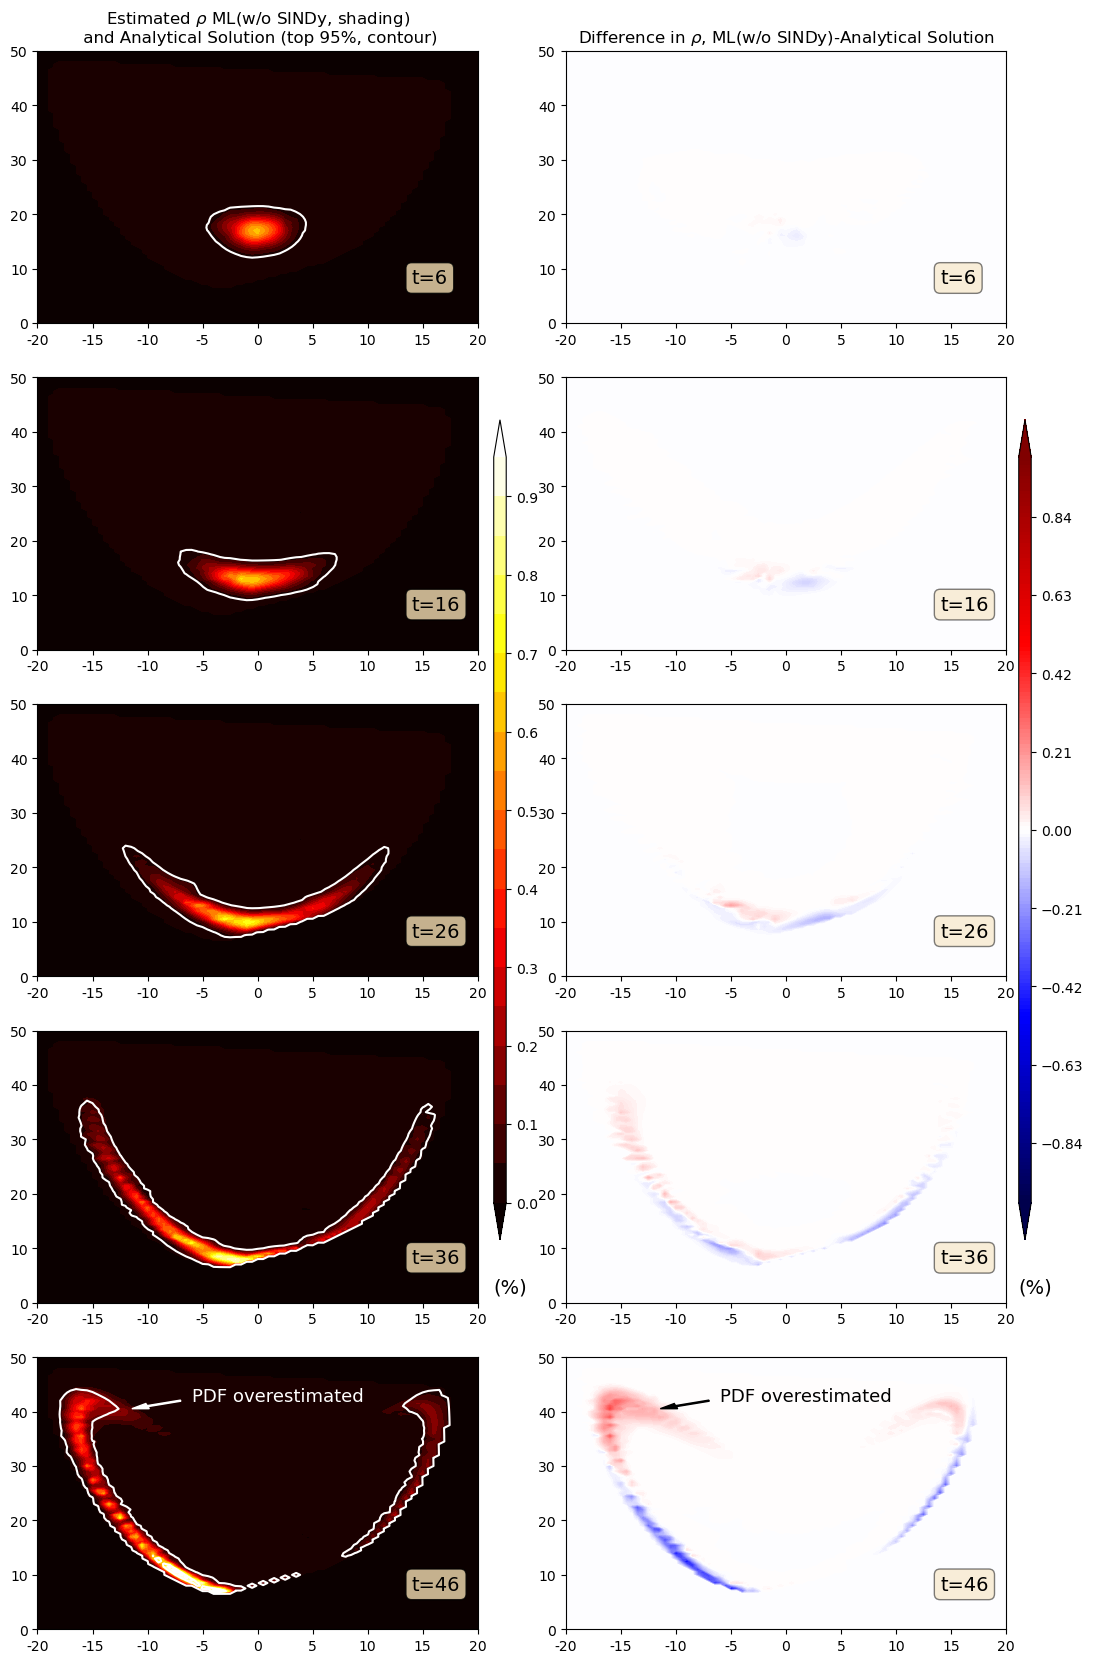

In [ ]:
print(np.shape(det_predict))
rho_ML        = np.zeros(np.shape(rho))
rho_numerical = np.zeros(np.shape(rho))
rho_SINDy     = np.zeros(np.shape(rho))

rho_ML[:,0]          = rho[:,0]
rho_numerical[:,0]   = rho[:,0]
rho_SINDy[:,0]       = rho[:,0]

for t in range(0,51):
    rho_ML[:,t+1] = np.reshape(np.reshape(rho_ML[:,t],[5000,1])*(1-np.array(series1[0+t:5000+t,])*0.05),[5000,])
    rho_ML[:,t+1] = rho_ML[:,t+1]/np.sum(rho_ML[:,t+1])

    rho_numerical[:,t+1] = np.reshape(np.reshape(rho_numerical[:,t],[5000,1])*(1-np.array(series2[0+t:5000+t,])*0.05),[5000,])
    rho_numerical[:,t+1] = rho_numerical[:,t+1]/np.sum(rho_numerical[:,t+1])

    rho_SINDy[:,t+1] = np.reshape(np.reshape(rho_SINDy[:,t],[5000,1])*(1-np.array(series3[0+t:5000+t,])*0.05),[5000,])
    rho_SINDy[:,t+1] = rho_SINDy[:,t+1]/np.sum(rho_SINDy[:,t+1])

    #print(np.shape(rho[:,0]*det_ML[0+t:5000+t,].T))


import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# target grid to interpolate to
xi = zi       = np.arange(-20,50.5,0.5)
xi,zi         = np.meshgrid(xi,zi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)


labels = ["6", "16", "26","36","46"]

threshold = np.percentile(rho_space_numerical,97)

fig, ax = plt.subplots(5, 2)
count = 0
for i in range(6,53,10):

    rho_space_ML        = griddata((Y_ML[0,i:5000+i],Y_ML[2,i:5000+i]),rho_ML[:,i],(xi,zi),method='linear')
    rho_space_numerical = griddata((Y_ML[0,i:5000+i],Y_ML[2,i:5000+i]),rho_numerical[:,i],(xi,zi),method='linear')
    rho_space_SINDy     = griddata((Y_ML[0,i:5000+i],Y_ML[2,i:5000+i]),rho_SINDy[:,i],(xi,zi),method='linear')

    posi = np.where(np.isnan(rho_space_ML))
    rho_space_ML[posi] = 0
    posi = np.where(np.isnan(rho_space_numerical))
    rho_space_numerical[posi] = 0
    posi = np.where(np.isnan(rho_space_SINDy))
    rho_space_SINDy[posi] = 0

    #plt.subplot(6,2,count*2-1)
    cs1=ax[count,0].contourf(xi,zi,rho_space_ML*100,levels=np.arange(0,1,0.05),cmap='hot',extend='both')
    ax[count,0].contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
    #plt.contour(xi[::4,::4],zi[::4,::4],rho_space_numerical[::4,::4],[threshold,threshold+0.01],colors='y',linestyles='dotted',linewidths=5)
    #plt.colorbar(cs)
    if count==0:
        ax[count,0].set_title(r'Estimated $\rho$ ML(w/o SINDy, shading)''\n and Analytical Solution (top 95%, contour)')
    if count==4:
        ax[count,0].text(-6,42,'PDF overestimated',color='w',fontsize=13)
        ax[count,0].arrow(-7,42,-3,-1,width=0.2,head_width=1,color='w')
    ax[count,0].set_ylim([0,50])
    ax[count,0].set_xlim([-20,20])
    ax[count,0].set_xticks(np.arange(-20,21,5))
    ax[count,0].set_xticklabels(['-20','-15','-10','-5','0','5','10','15','20'])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax[count,0].text(0.85, 0.2,'t='+str(i), transform=ax[count,0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)



    #ax.subplot(6,2,count*2)
    cs2=ax[count,1].contourf(xi,zi,(rho_space_ML-rho_space_numerical)*100,levels=np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
    #ax[count+1,1].colorbar(cs)
    ax[count,1].set_ylim([0,50])
    ax[count,1].set_xlim([-20,20])
    ax[count,1].set_xticks(np.arange(-20,21,5))
    ax[count,1].set_xticklabels(['-20','-15','-10','-5','0','5','10','15','20'])
    if count==0:
        ax[count,1].set_title(r'Difference in $\rho$, ML(w/o SINDy)-Analytical Solution')
    #plt.legend(cs2,["This is my legend"], fontsize="x-large")
    #ax [count,1].= ax.flatten()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[count,1].text(0.85, 0.2,'t='+str(i), transform=ax[count,1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    if count==4:
        ax[count,1].text(-6,42,'PDF overestimated',color='k',fontsize=13)
        ax[count,1].arrow(-7,42,-3,-1,width=0.2,head_width=1,color='k')
    #ax[count+1,2].set_yticks(fontsize=18)
    #ax[count+1,2].set_xticks(fontsize=18)
    count = count+1
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.91, 0.30, 0.01, 0.4])
cbar    = fig.colorbar(cs2, cax=cbar_ax)
cbar_ax.text(0,  -0.1,'(%)', transform=cbar_ax.transAxes, fontsize=14,
        verticalalignment='top')

cbar_ax = fig.add_axes([0.49, 0.30, 0.01, 0.4])
cbar2   = fig.colorbar(cs1, cax=cbar_ax)
cbar_ax.text(0,  -0.1,'(%)', transform=cbar_ax.transAxes, fontsize=14,
        verticalalignment='top')

#plt.colorbar(cs1, ax=ax[0])


#cbaxes = fig.add_axes([0.5, 0.4, 0.005, 0.4])
#cb1    = plt.colorbar(cs1, cax = cbaxes, orientation="vertical")
#cb1.ax.tick_params(labelsize=15)
#cb1.ax.text(0.45,-0.2,' %', va='center',fontsize=12)

fig.set_size_inches(12.5, 20.5)
fig.savefig('time_evolution_ML_noSINDy.jpg', dpi=300, bbox_inches='tight')


(1, 7000)


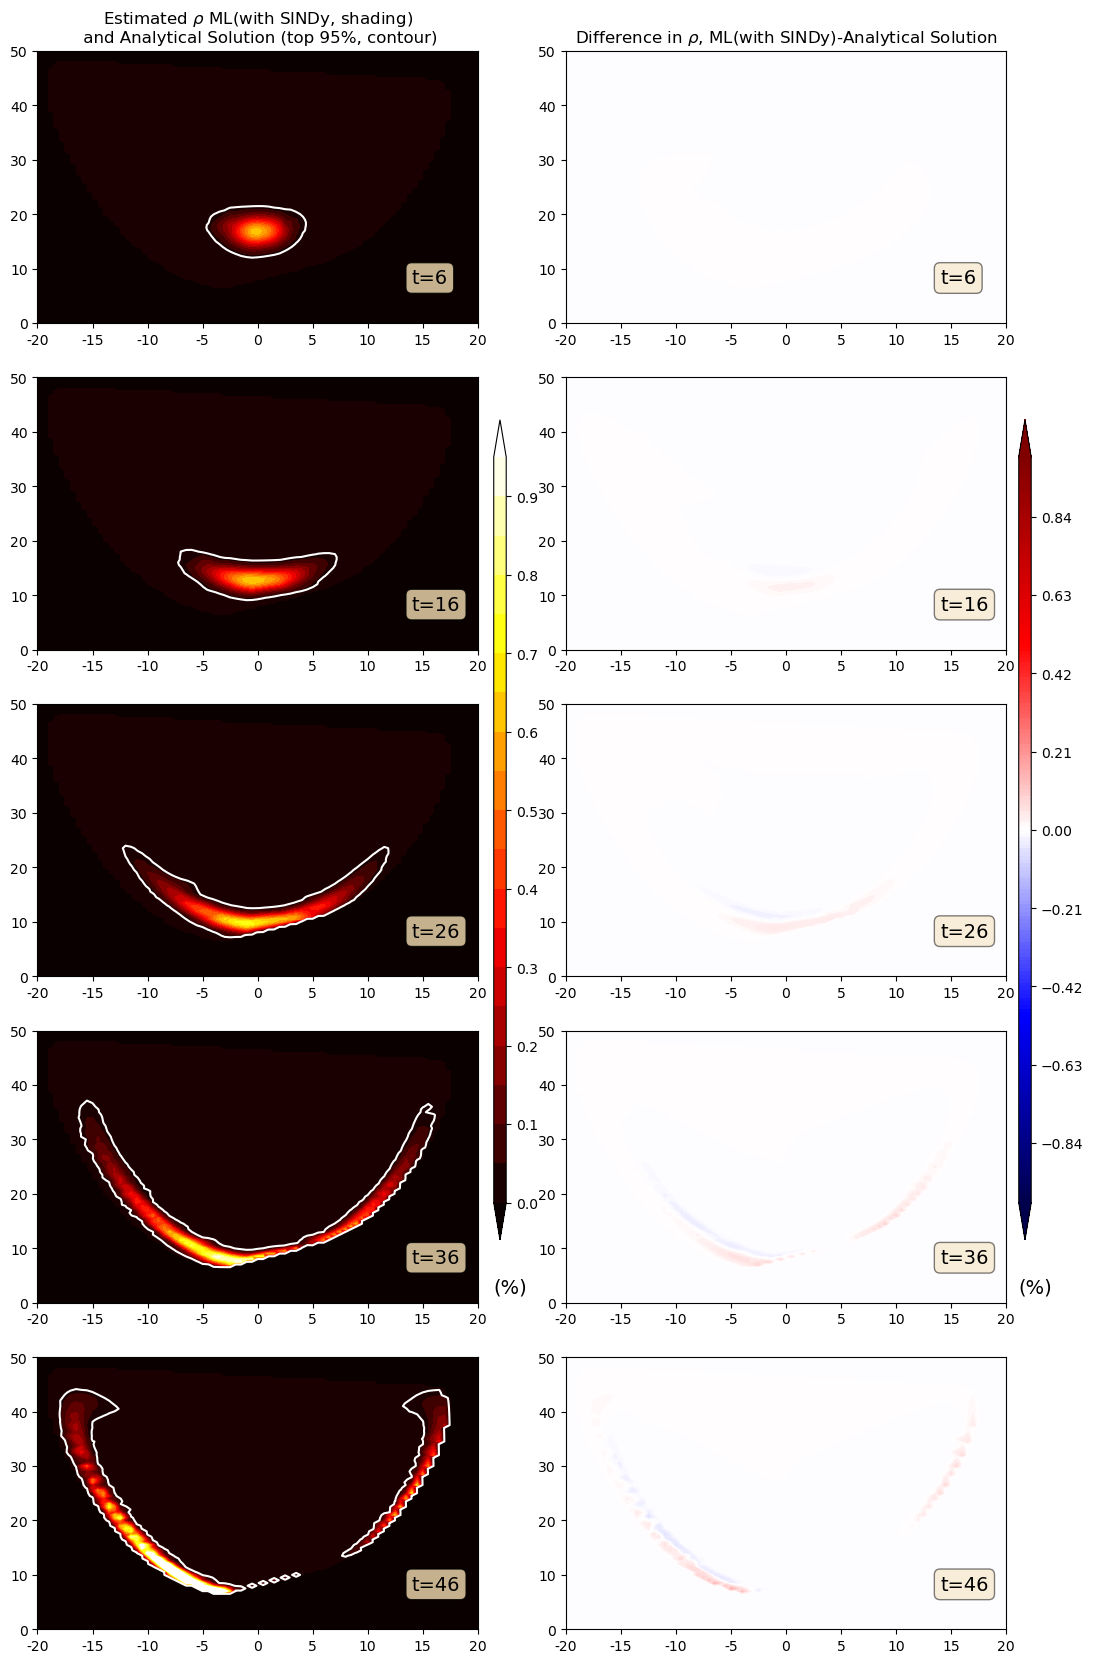

In [ ]:
print(np.shape(det_predict))
rho_ML        = np.zeros(np.shape(rho))
rho_numerical = np.zeros(np.shape(rho))
rho_SINDy     = np.zeros(np.shape(rho))

rho_ML[:,0]          = rho[:,0]
rho_numerical[:,0]   = rho[:,0]
rho_SINDy[:,0]       = rho[:,0]

for t in range(0,51):
    rho_ML[:,t+1] = np.reshape(np.reshape(rho_ML[:,t],[5000,1])*(1-np.array(series1[0+t:5000+t,])*0.05),[5000,])
    rho_ML[:,t+1] = rho_ML[:,t+1]/np.sum(rho_ML[:,t+1])

    rho_numerical[:,t+1] = np.reshape(np.reshape(rho_numerical[:,t],[5000,1])*(1-np.array(series2[0+t:5000+t,])*0.05),[5000,])
    rho_numerical[:,t+1] = rho_numerical[:,t+1]/np.sum(rho_numerical[:,t+1])

    rho_SINDy[:,t+1] = np.reshape(np.reshape(rho_SINDy[:,t],[5000,1])*(1-np.array(series3[0+t:5000+t,])*0.05),[5000,])
    rho_SINDy[:,t+1] = rho_SINDy[:,t+1]/np.sum(rho_SINDy[:,t+1])

    #print(np.shape(rho[:,0]*det_ML[0+t:5000+t,].T))


import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# target grid to interpolate to
xi = zi       = np.arange(-20,50.5,0.5)
xi,zi         = np.meshgrid(xi,zi)

## set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)


labels = ["6", "16", "26","36","46"]

threshold = np.percentile(rho_space_numerical,97)

fig, ax = plt.subplots(5, 2)
count = 0
for i in range(6,53,10):

    rho_space_ML        = griddata((Y_ML[0,i:5000+i],Y_ML[2,i:5000+i]),rho_ML[:,i],(xi,zi),method='linear')
    rho_space_numerical = griddata((Y_ML[0,i:5000+i],Y_ML[2,i:5000+i]),rho_numerical[:,i],(xi,zi),method='linear')
    rho_space_SINDy     = griddata((Y_ML[0,i:5000+i],Y_ML[2,i:5000+i]),rho_SINDy[:,i],(xi,zi),method='linear')

    posi = np.where(np.isnan(rho_space_ML))
    rho_space_ML[posi] = 0
    posi = np.where(np.isnan(rho_space_numerical))
    rho_space_numerical[posi] = 0
    posi = np.where(np.isnan(rho_space_SINDy))
    rho_space_SINDy[posi] = 0

    #plt.subplot(6,2,count*2-1)
    cs1=ax[count,0].contourf(xi,zi,rho_space_SINDy*100,levels=np.arange(0,1,0.05),cmap='hot',extend='both')
    ax[count,0].contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
    #plt.contour(xi[::4,::4],zi[::4,::4],rho_space_numerical[::4,::4],[threshold,threshold+0.01],colors='y',linestyles='dotted',linewidths=5)
    #plt.colorbar(cs)
    if count==0:
        ax[count,0].set_title(r'Estimated $\rho$ ML(with SINDy, shading)''\n and Analytical Solution (top 95%, contour)')

    ax[count,0].set_ylim([0,50])
    ax[count,0].set_xlim([-20,20])
    ax[count,0].set_xticks(np.arange(-20,21,5))
    ax[count,0].set_xticklabels(['-20','-15','-10','-5','0','5','10','15','20'])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax[count,0].text(0.85, 0.2,'t='+str(i), transform=ax[count,0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)



    #ax.subplot(6,2,count*2)
    cs2=ax[count,1].contourf(xi,zi,(rho_space_SINDy-rho_space_numerical)*100,levels=np.arange(-1,1.01,0.01),cmap='seismic',extend='both')
    #ax[count+1,1].colorbar(cs)
    ax[count,1].set_ylim([0,50])
    ax[count,1].set_xlim([-20,20])
    ax[count,1].set_xticks(np.arange(-20,21,5))
    ax[count,1].set_xticklabels(['-20','-15','-10','-5','0','5','10','15','20'])
    if count==0:
        ax[count,1].set_title(r'Difference in $\rho$, ML(with SINDy)-Analytical Solution')
    #plt.legend(cs2,["This is my legend"], fontsize="x-large")
    #ax [count,1].= ax.flatten()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[count,1].text(0.85, 0.2,'t='+str(i), transform=ax[count,1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

    #ax[count+1,2].set_yticks(fontsize=18)
    #ax[count+1,2].set_xticks(fontsize=18)
    count = count+1
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.91, 0.30, 0.01, 0.4])
cbar    = fig.colorbar(cs2, cax=cbar_ax)
cbar_ax.text(0,  -0.1,'(%)', transform=cbar_ax.transAxes, fontsize=14,
        verticalalignment='top')

cbar_ax = fig.add_axes([0.49, 0.30, 0.01, 0.4])
cbar2   = fig.colorbar(cs1, cax=cbar_ax)
cbar_ax.text(0,  -0.1,'(%)', transform=cbar_ax.transAxes, fontsize=14,
        verticalalignment='top')

#plt.colorbar(cs1, ax=ax[0])


#cbaxes = fig.add_axes([0.5, 0.4, 0.005, 0.4])
#cb1    = plt.colorbar(cs1, cax = cbaxes, orientation="vertical")
#cb1.ax.tick_params(labelsize=15)
#cb1.ax.text(0.45,-0.2,' %', va='center',fontsize=12)

fig.set_size_inches(12.5, 20.5)
fig.savefig('time_evolution_ML_SINDy.jpg', dpi=300, bbox_inches='tight')

In [ ]:
# make animation
t  = 48
for t in range(50):
    fig = plt.figure()
    # target grid to interpolate to
    xi = zi       = np.arange(-20,50.1,0.1)
    xi,zi         = np.meshgrid(xi,zi)

    ## set mask
    #mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

    # interpolate
    rho_space_ML        = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_ML[:,t],(xi,zi),method='linear')
    rho_space_numerical = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_numerical[:,t],(xi,zi),method='linear')
    rho_space_SINDy     = griddata((Y_ML[0,t:5000+t],Y_ML[2,t:5000+t]),rho_SINDy[:,t],(xi,zi),method='linear')

    posi = np.where(np.isnan(rho_space_ML))
    rho_space_ML[posi] = 0
    posi = np.where(np.isnan(rho_space_numerical))
    rho_space_numerical[posi] = 0
    posi = np.where(np.isnan(rho_space_SINDy))
    rho_space_SINDy[posi] = 0


    threshold = np.percentile(rho_space_numerical,99.5-t*0.04)



    plt.subplot(1,3,1)
    cs2=plt.contourf(xi,zi,rho_space_numerical,levels=np.arange(0,0.004,0.0001),cmap='hot',extend='both')
    plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim([0,50])
    plt.xlim([-20,20])
    plt.title(r'(d) Analytical Solution of PDF',fontsize=18)


    plt.subplot(1,3,2)
    cs2=plt.contourf(xi,zi,rho_space_ML,levels=np.arange(0,0.004,0.0001),cmap='hot',extend='both')
    cs3=plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w')
    h1,l1 = cs2.legend_elements()
    h2,l1 = cs3.legend_elements()
    plt.legend([h1[0], h2[0]], ['Shading: Model', 'ContourTruth (top 95%)'])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim([0,50])
    plt.xlim([-20,20])
    plt.title(r'(e) Estimated PDF '+'\n from Reservoir Computing ',fontsize=18)

    plt.subplot(1,3,3)
    cs2=plt.contourf(xi,zi,rho_space_SINDy,levels=np.arange(0,0.004,0.0001),cmap='hot',extend='both',labels='Model')
    plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w',label='Truth (top 95%)')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim([0,50])
    plt.xlim([-20,20])
    plt.title(r'(f) Estimated PDF'+'\n from LE',fontsize=18)


    cbaxes = fig.add_axes([0.91, 0.25, 0.01, 0.5])
    cb = plt.colorbar(cs2, cax = cbaxes, orientation="vertical")
    cb.ax.tick_params(labelsize=15)


    #fig.tight_layout(pad=0.1)
    #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    fig.set_size_inches(30.5, 6)
    plt.savefig(str(t).zfill(2)+".png")
    plt.close(fig)

/tmp/ipykernel_79600/2321577044.py:51: UserWarning: The following kwargs were not used by contour: 'labels'
  cs2=plt.contourf(xi,zi,rho_space_SINDy,levels=np.arange(0,0.004,0.0001),cmap='hot',extend='both',labels='Model')
/tmp/ipykernel_79600/2321577044.py:52: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xi,zi,rho_space_numerical,[threshold,threshold+0.01],colors='w',label='Truth (top 95%)')


In [ ]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "*.png"
fp_out = "image.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [ ]:
import numpy as np

def f(x):
    # Your machine learning model implementation
    # This could be any complex function or model you are working with
    # input has dimension of I*1, where I is number of state
    # output should be the next time step of x with the same dimension
    return result

def estimate_tangent_linear(x, epsilon=1e-6, ens=N):
    # Create a matrix of ensembles
    # matrix has dimension of I*N, N is the total number of ensemble
    x_original = np.tile(x, (1, ens))

    # adding perturbation to each ensemble
    x_perturb  = x_original + np.random.normal(0, epsilon, size=np.shape(x_original))

    # Calculate the slope matrix
    G          = f(x_perturb).dot(x_perturb.T).dot(np.linalg.inv(x_perturb.dot(x_perturb.T)))

    return G

# Example usage
x_vector = np.array([1.0, 2.0, 3.0])
tangent_linear_estimates = estimate_tangent_linear(x_vector)

# Display or use the tangent linear estimates as needed
print(tangent_linear_estimates)


In [ ]:
import numpy as np

def f(x):
    return x+np.square(x)*0.01  # Quadratic function as an example

def estimate_tangent_linear(x, epsilon=1e-6, ens=10):
    x_original         = np.tile(x, (1, ens))
    x_perturb          = np.tile(x, (1, ens)) + np.random.normal(0, 0.001, size=np.shape(x_original))
    G1                  = f(x_perturb).dot(x_perturb.T).dot(np.linalg.inv(x_perturb.dot(x_perturb.T)))
    G2                  = np.linalg.lstsq(x_perturb.T, f(x_perturb).T, rcond=None)[0].T
    return G1,G2

# Example usage
x_vector = np.matrix([1.0, 2.0, 3.0])
G1,G2        = estimate_tangent_linear(x_vector.T)

# Display the results
print("Original x:", x_vector)
print("Tangent Linear Estimates:", G1)


Original x: [[1. 2. 3.]]
Tangent Linear Estimates: [[ 1.01805318e+00 -6.37555802e-04 -2.25953632e-03]
 [-7.79784846e-03  1.03744982e+00 -9.03465646e-03]
 [-1.75343271e-02 -5.73131897e-03  1.03966401e+00]]


In [ ]:
def SINDy(det,X):
    # the input is determinant of G as a function of phase space X
    # theta_i is the i_th candidate function such as X, X^2, X^3..., one can add as many candidate functions as possible
    # theta is the aggregation of all theta_i
    # Each element in theta is labeled as (location_index * function_index)
    # location_index is the ID of location. For example, in Lorenz problem, we can assign an ID to a given set of locations X=(x,y,z)
    # function_index is the ID of candidate functions.
    theta             = np.matrix([theta_1(x),theta_2(x),theta_3(x),theta_4(x)])

    # Estimate regression coefficient with normal equation
    coef              = np.linalg.inv(theta.T.dot(theta)).dot(theta.T).dot(det)
    return coef



def normal_equation(predictor,predictant, using_bias=False):
    if using_bias:
        # predictor should have a dimension of time X number of predictors
        X_mat              = np.vstack((np.ones(predictor.shape[0]), predictor)).T

        # coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
        # coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a
        # predictamt should have dimension of time X number of targets
        coef               = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(predictant)

    else:
        # predictor should have a dimension of time X number of predictors
        X_mat              = predictor.T

        # coef_total = (X^T X)^(-1) (X^T Y) (you can check wikipedia: https://en.wikipedia.org/wiki/Linear_regression, section: Least-squares estimation and related techniques)
        # coef_total contains both b and a. the first dimension of coef_total is b and the second dimension of coef_total is a
        # predictamt should have dimension of time X number of targets
        coef               = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(predictant)

    return coef



(3, 1)